### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import gensim.downloader as api

### Import Data

In [2]:
dataset = api.load("text8")
data = [i for i in dataset]

In [3]:
len(data)

1701

In [4]:
len(data[0])

10000

In [5]:
data[0]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are',
 'differing',
 '

## Pre-Processing
> Lowercase Conversion

> Punctuation Removal

> Stopwords Removal

> Lemmatization

In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

from nltk import word_tokenize, pos_tag
from collections import defaultdict

stop_words = stopwords.words('english')
lem = WordNetLemmatizer()

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def custom_lemmatize(t):
    lemmas = []
    for token, tag in pos_tag(t):
        lemma = lem.lemmatize(token, tag_map[tag[0]])
        lemmas.append(lemma)
    return lemmas

def preprocess(w):
    words = []
    for word in w:
        if word not in stop_words:
            word = re.sub(f'[^a-zA-Z]',' ', word).lower()
            words.append(word)
    words = custom_lemmatize(words) 
    return words

In [7]:
tokens = [preprocess(words) for words in data]

In [8]:
tokens[0]

['anarchism',
 'originated',
 'term',
 'abuse',
 'first',
 'use',
 'early',
 'working',
 'class',
 'radical',
 'include',
 'digger',
 'english',
 'revolution',
 'sans',
 'culottes',
 'french',
 'revolution',
 'whilst',
 'term',
 'still',
 'use',
 'pejorative',
 'way',
 'describe',
 'act',
 'use',
 'violent',
 'mean',
 'destroy',
 'organization',
 'society',
 'also',
 'take',
 'positive',
 'label',
 'self',
 'define',
 'anarchist',
 'word',
 'anarchism',
 'derive',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'political',
 'philosophy',
 'belief',
 'ruler',
 'unnecessary',
 'abolish',
 'although',
 'differ',
 'interpretation',
 'mean',
 'anarchism',
 'also',
 'refers',
 'relate',
 'social',
 'movement',
 'advocate',
 'elimination',
 'authoritarian',
 'institution',
 'particularly',
 'state',
 'word',
 'anarchy',
 'anarchist',
 'use',
 'imply',
 'chaos',
 'nihilism',
 'anomie',
 'rather',
 'harmonious',
 'anti',
 'authoritarian',
 'society',
 'place',
 'r

### Train Model
Use Doc2Vec

In [9]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [10]:
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield TaggedDocument(list_of_words, [i]) 

In [11]:
training_data = list(tagged_document(tokens))
model = Doc2Vec(vector_size=200, min_count=1, epochs=30)
 
model.build_vocab(training_data)
model.train(training_data, total_examples=len(training_data), epochs=model.epochs)

In [12]:
model.corpus_count

1701

In [13]:
documents = ['community of biblical scholars support the documentary hypothesis', 
             'this hypothesis is supported by scholars']

In [14]:
tokens = [preprocess(word_tokenize(sentence)) for sentence in documents]

In [15]:
tokens

[['community', 'biblical', 'scholar', 'support', 'documentary', 'hypothesis'],
 ['hypothesis', 'support', 'scholar']]

In [16]:
vectors = [model.infer_vector([word for word in sent]).reshape(1,-1) for sent in tokens]

In [17]:
cosine_similarity(vectors[0],vectors[1])

array([[0.7854433]], dtype=float32)

In [18]:
documents_2 = ['children are playing in the yard', 'young boys are playing outdoors']

In [19]:
tokens2 = [preprocess(word_tokenize(sentence)) for sentence in documents_2]

In [20]:
tokens2

[['child', 'play', 'yard'], ['young', 'boy', 'play', 'outdoors']]

In [21]:
vectors_2 = [model.infer_vector([word for word in sent]).reshape(1,-1) for sent in tokens2]

In [22]:
cosine_similarity(vectors_2[0],vectors_2[1])

array([[0.23017943]], dtype=float32)

# Visualize Doc2Vec Model using t-SNE

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,200), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_vector(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot
    sns.set()
    plt.figure(figsize=(10, 7))
    plt.scatter(x_coords, y_coords,c=np.arctan2(x_coords, y_coords), cmap='rainbow', s=100)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    with sns.axes_style('dark'):
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.suptitle('Words close to the word {}'.format(word), fontsize=20)
    plt.show()

C:\Users\april\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\april\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


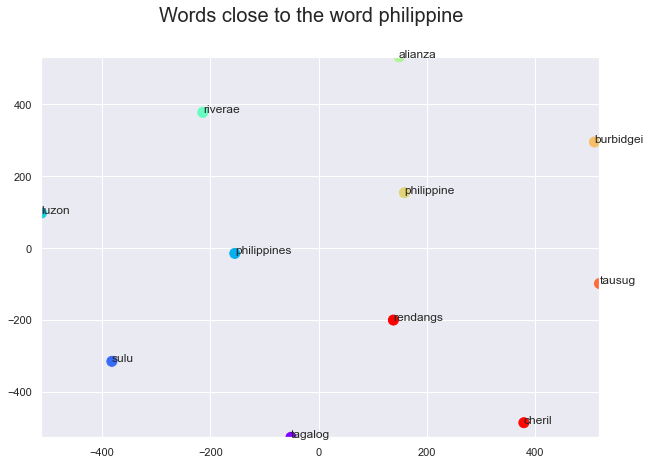

In [150]:
display_closestwords_tsnescatterplot(model, 'philippine')

In [152]:
close_words1 = model.wv.similar_by_vector("philippine")
close_words1

[('philippines', 0.5278804302215576),
 ('riverae', 0.5036576986312866),
 ('cheril', 0.4987106919288635),
 ('sulu', 0.49302637577056885),
 ('alianza', 0.49134641885757446),
 ('tagalog', 0.4901016354560852),
 ('rendangs', 0.4810175597667694),
 ('luzon', 0.47932010889053345),
 ('burbidgei', 0.4768061339855194),
 ('tausug', 0.47508934140205383)]

C:\Users\april\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\april\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


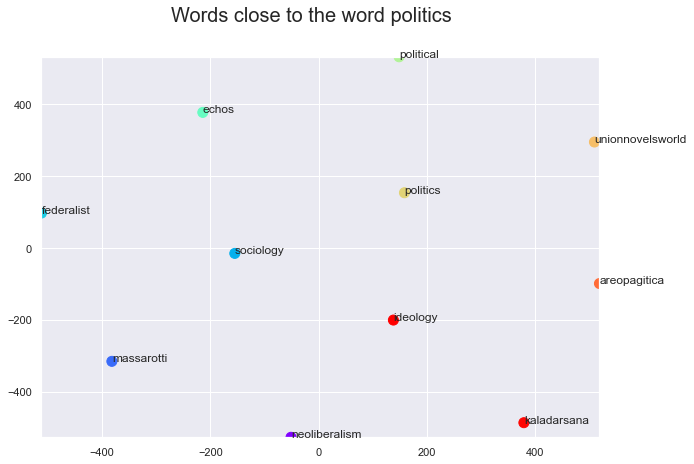

In [26]:
display_closestwords_tsnescatterplot(model, 'politics')

In [27]:
close_words1 = model.wv.similar_by_vector("politics")
close_words1

[('sociology', 0.4263443052768707),
 ('echos', 0.4110724925994873),
 ('kaladarsana', 0.3903530538082123),
 ('massarotti', 0.38772323727607727),
 ('political', 0.38665950298309326),
 ('neoliberalism', 0.37191030383110046),
 ('ideology', 0.365980863571167),
 ('federalist', 0.36587533354759216),
 ('unionnovelsworld', 0.36584052443504333),
 ('areopagitica', 0.3621692359447479)]

In [62]:
def documents_tsne_plot(model):
    tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=2,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
    tsne_d2v = tsne_model.fit_transform(model.dv.vectors)
    
    # Putting the tsne information into sq
    tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["x", "y"])
    
    plt.figure(figsize=(12,4))
    cmap = plt.cm.get_cmap('jet')
    plt.scatter(tsne_d2v[:len(tsne_d2v_df['y']),0], tsne_d2v[:len(tsne_d2v_df['y']),1], alpha=0.5, cmap=cmap, s=20)
    plt.colorbar()
    plt.suptitle('2-Dimensional Representation of the Data using t-SNE')
    plt.show()

C:\Users\april\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\april\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1701 samples in 0.000s...
[t-SNE] Computed neighbors for 1701 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1701
[t-SNE] Computed conditional probabilities for sample 1701 / 1701
[t-SNE] Mean sigma: 5.663270
[t-SNE] KL divergence after 250 iterations with early exaggeration: 20.325150
[t-SNE] KL divergence after 300 iterations: 2.758201


C:\Users\april\AppData\Local\Temp\ipykernel_23380\1440427085.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


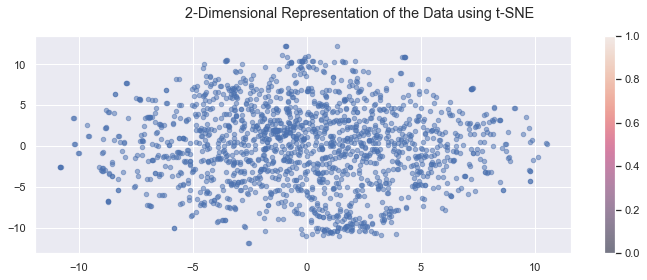

In [63]:
documents_tsne_plot(model)

In [65]:
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=2,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(model.dv.vectors)
    
    # Putting the tsne information into sq
tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["x", "y"])

C:\Users\april\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\april\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1701 samples in 0.001s...
[t-SNE] Computed neighbors for 1701 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1701
[t-SNE] Computed conditional probabilities for sample 1701 / 1701
[t-SNE] Mean sigma: 5.663270
[t-SNE] KL divergence after 250 iterations with early exaggeration: 20.325150
[t-SNE] KL divergence after 300 iterations: 2.758201


In [94]:
tsne_d2v_df['documents']=data

In [95]:
tsne_d2v_df.head()

,x,y,documents
0,-2.743464,-3.316874,"[anarchism, originated, as, a, term, of, abuse..."
1,4.444189,-0.241329,"[reciprocity, qualitative, impairments, in, co..."
2,-5.412363,0.948266,"[with, the, aegis, of, zeus, when, he, goes, t..."
3,-5.441809,0.922001,"[despite, his, injury, booth, managed, to, lim..."
4,-3.640057,0.026921,"[present, best, sound, editing, one, nine, six..."


In [107]:
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
import bokeh.plotting as bp
import matplotlib as mpl

In [ ]:
output_notebook()
plot_d2v = bp.figure(plot_width = 800, plot_height = 700, 
                       title = "T-SNE applied to Doc2vec document embeddings",
                       tools = "pan, wheel_zoom, box_zoom, reset, hover",
                       x_axis_type = None, y_axis_type = None, min_border = 1)

# colormap = np.array(["#6d8dca", "#d07d3c"])
colormap = np.array(["darkblue", "cyan"])

# palette = d3["Category10"][len(tsne_tfidf_df["asset_name"].unique())]
source = ColumnDataSource(data = dict(x = tsne_d2v_df["x"], 
                                      y = tsne_d2v_df["y"],
                                      colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 
                                                  255*mpl.cm.jet(mpl.colors.Normalize()(tsne_d2v_df["y"].values))],
                                      document_vector = tsne_d2v_df["documents"]))

plot_d2v.scatter(x = "x", 
                   y = "y", 
                   color="rainbow",
                   source = source,
                   alpha = 0.7)
hover = plot_d2v.select(dict(type = HoverTool))
hover.tooltips = {"document_vector": "@document_vector"}

hover_tsne = HoverTool(names=["test"], tooltips=[("document_vector", "@document_vector")])
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=600, plot_height=600, tools=tools_tsne, title='Representation of the data using t-SNE')
plot_tsne.square('x', 'y', size=7, fill_color='colors', 
                 alpha=0.9, line_width=0, source=source, name="test")

#show(plot_d2v)
show(plot_tsne)

In [120]:
from bokeh.plotting import figure, output_file, save

output_file("data_t-SNE.html")
save(plot_tsne)

'C:\\Users\\april\\Desktop\\PythonLabs_Term2\\AML 2304\\Final Project\\data_t-SNE.html'

### Save Model

In [28]:
model.save('textsimilaritychecker.model')
print('Model saved successfully.')

Model saved successfully.


### Load and Test Model

In [29]:
loaded_model= Doc2Vec.load("textsimilaritychecker.model")

In [30]:
new_vectors = [loaded_model.infer_vector([word for word in sent]).reshape(1,-1) for sent in tokens]

In [31]:
cosine_similarity(new_vectors[0],new_vectors[1])

array([[0.7901232]], dtype=float32)

In [32]:
new_vectors = [loaded_model.infer_vector([word for word in sent]).reshape(1,-1) for sent in tokens2]

In [33]:
cosine_similarity(new_vectors[0],new_vectors[1])

array([[0.18426688]], dtype=float32)

In [123]:
par1 = "She put the pen to paper but she couldn't bring herself to actually write anything. She just stared at the blank card and wondered what words she could write that would help in even a small way. She thought of a dozen ways to begin but none seemed to do justice to the situation. There were no words that could help and she knew it."
par2 = "He collected the plastic trash on a daily basis. It never seemed to end. Even if he cleaned the entire beach, more plastic would cover it the next day after the tide had come in. Although it was a futile effort that would never be done, he continued to pick up the trash each day."

pars = [par1,par2]

In [126]:
par_tokens = [preprocess(word_tokenize(sentence)) for sentence in pars]

In [127]:
par_vectors = [loaded_model.infer_vector([word for word in sent]).reshape(1,-1) for sent in par_tokens]

In [128]:
cosine_similarity(par_vectors[0],par_vectors[1])

array([[0.51993775]], dtype=float32)

In [139]:
par1 = "Every day, he gathered the rubbish made of plastic. It seemed to go on forever. Even if he completely cleaned the beach, the following day's incoming tide would cause additional plastic to cover it. He proceeded to pick up the rubbish every day even though it was a pointless endeavour that would never be completed."
par2 = "He collected the plastic trash on a daily basis. It never seemed to end. Even if he cleaned the entire beach, more plastic would cover it the next day after the tide had come in. Although it was a futile effort that would never be done, he continued to pick up the trash each day."

pars = [par1,par2]

In [140]:
par_tokens = [preprocess(word_tokenize(sentence)) for sentence in pars]

In [141]:
par_vectors = [loaded_model.infer_vector([word for word in sent]).reshape(1,-1) for sent in par_tokens]

In [142]:
cosine_similarity(par_vectors[0],par_vectors[1])

array([[0.73752874]], dtype=float32)

In [147]:
score = round(cosine_similarity(par_vectors[0],par_vectors[1])[0][0] * 100, 2)
score

73.75

# TF-IDF 
## Cosine Similarity

In [34]:
tfidf_vectorizer = TfidfVectorizer()
sparse_matrix = tfidf_vectorizer.fit_transform(documents_2)

In [35]:
documents_2

['children are playing in the yard', 'young boys are playing outdoors']

In [36]:
cosine_similarity(sparse_matrix[0],sparse_matrix[1])

array([[0.22576485]])

In [37]:
sparse_matrix = tfidf_vectorizer.fit_transform(documents)

In [38]:
documents

['community of biblical scholars support the documentary hypothesis',
 'this hypothesis is supported by scholars']

In [39]:
cosine_similarity(sparse_matrix[0],sparse_matrix[1])

array([[0.17077611]])

In [134]:
sparse_matrix = tfidf_vectorizer.fit_transform(pars)

In [135]:
cosine_similarity(sparse_matrix[0],sparse_matrix[1])

array([[0.61701751]])

In [153]:
pars

["Every day, he gathered the rubbish made of plastic. It seemed to go on forever. Even if he completely cleaned the beach, the following day's incoming tide would cause additional plastic to cover it. He proceeded to pick up the rubbish every day even though it was a pointless endeavour that would never be completed.",
 'He collected the plastic trash on a daily basis. It never seemed to end. Even if he cleaned the entire beach, more plastic would cover it the next day after the tide had come in. Although it was a futile effort that would never be done, he continued to pick up the trash each day.']

## Euclidian Distance

In [40]:
from sklearn.metrics.pairwise import euclidean_distances

In [41]:
euclidean_distances(sparse_matrix[0],sparse_matrix[1])

array([[1.28780735]])

In [148]:
euclidean_distances(vectors[0],vectors[1])

array([[1.0953785]], dtype=float32)

In [150]:
tfidf_vectorizer.get_feature_names()

C:\Users\april\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['biblical',
 'by',
 'community',
 'documentary',
 'hypothesis',
 'is',
 'of',
 'scholars',
 'support',
 'supported',
 'the',
 'this']

In [136]:
euclidean_distances(sparse_matrix[0],sparse_matrix[1])

array([[0.87519425]])

## Jaccard Distance

In [ ]:
from gensim import matutils

In [122]:
tokens

[['community', 'biblical', 'scholar', 'support', 'documentary', 'hypothesis'],
 ['hypothesis', 'support', 'scholar']]

In [42]:
matutils.jaccard(tokens[0],tokens[1])

0.5

In [121]:
tokens2

[['child', 'play', 'yard'], ['young', 'boy', 'play', 'outdoors']]

In [43]:
matutils.jaccard(tokens2[0],tokens2[1])

0.8333333333333334

In [138]:
matutils.jaccard(par_tokens[0],par_tokens[1])

0.6818181818181819